# Gatekeeper Challenge

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

In [5]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'

In [ ]:
%run "/home/dakshina/projects/csaw_esc_2025/challenges/setup/Setup_Generic.ipynb"   # Load generic setup
scope.adc.samples = 100000

INFO: Found ChipWhisperer😍


In [ ]:
cw.program_target(scope, prog, "/home/dakshina/projects/csaw_esc_2025/challenges/set1/gatekeeper-CWNANO.hex")   # Program the target device

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6279 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6279 bytes


## Gatekeeper 1

In [82]:
# Gatekeeper 1: 8 character flag, lowercase alpha or numeric
scope.arm()

target.simpleserial_write('a', b"gk1{l0g1npwn}") #l0g1npwn
ret = scope.capture()
if ret:
    print('Timeout happened during acquisition')
correct_power_trace = scope.get_last_trace()
response = target.simpleserial_read('r', 1)
if response is not None:
    print(f"Gatekeeper1 Success (0x01 if correct): {response.hex()}") #0x01 if correct
    
target.simpleserial_write('q', b"0")
response = target.simpleserial_read('r', 4)
if response is not None:
    print(f"Number of Queries (cumulative): {int.from_bytes(response, byteorder='little', signed=False)}") #number of queries since powerup

Gatekeeper1 Success (0x01 if correct): 01
Number of Queries (cumulative): 1


In [ ]:
flag_length = 8

# Define empty array to store the recovered flag characters
flag = ['1'] * 8

#TODO: Adjust these values based on the trace analysis
period = 1400
initial_offset = 5600

# Define random character as the first character from lowercase alpha or numeric list
char_list = string.ascii_lowercase + string.digits
# flag[0] = random.choice(char_list)

# Loop through each position in the flag
for position in range(8):
    power_traces = []
    # Iterate through each character in the character list  
    for char in char_list:
        flag[position] = char

        ## TODO ##
        # if position < flag_length - 1:
        #     # Call LLM for the best guess character list for the current position
        #     # For demonstration purposes, we will use a random character from the char_list
        #     flag[position] = random.choice(char_list)
        
        print(f"Trying position {position} with character '{flag[position]}'")
        
        # Construct the flag guess
        flag_guess = "gk1{" + ''.join(flag) + "}"
        print(f"Flag Guess: {flag_guess}")
        flag_guess = flag_guess.encode('utf-8')

        # Arm the Chipwhisper
        scope.arm()

        # Send the guess to the target
        target.simpleserial_write('a', flag_guess) #l0g1npwn

        # Capture the power trace
        ret = scope.capture()
        if ret:
            print('Timeout happened during acquisition')

        # Read the device response
        response = target.simpleserial_read('r', 1)

        # Read the power trace from the ChipWhisperer Nano
        power_trace = scope.get_last_trace()

        # Append the power trace to the list of power traces
        power_traces.append(power_trace[initial_offset+period*position:initial_offset+period*position+period])

        if response is not None:
            print(f"Gatekeeper1 response (0x01 if correct): {response.hex()}") #0x01 if correct

        # If the response is 0x01, we have found the correct flag exit the loop
        if response == b'\x01':
            print(f"Correct flag found: {flag_guess}")
            break
        
        if (len(power_traces) > 1):
            # Perform Hybrid Clustering-CPA analysis on the collected power traces
            # Utilize k-means clustering to group similar traces
            num_clusters = 2
            kmeans = KMeans(n_clusters=num_clusters, random_state=0)
            kmeans.fit(power_traces)
            labels = kmeans.labels_

            # Get the average trace for each cluster
            avg_traces = []
            for cluster in range(num_clusters):
                cluster_traces = np.array(power_traces)[labels == cluster]
                avg_trace = np.mean(cluster_traces, axis=0)
                avg_traces.append(avg_trace)

            # Calculate the pearson correlation coefficient between the average traces using peasonr from scipy
            correlations = pearsonr(avg_traces[0], avg_traces[1])[0]
            print(f"Pearson correlation coefficient between average traces: {correlations}")

            # If the correlation is below a certain threshold, we can assume that the character is correct
            if correlations < 0.9:
                print(f"Character '{flag[position]}' at position {position} is likely correct.")

                # Break out of the inner loop to move to the next position
                break
        
    # If the response is 0x01, we have found the correct flag exit the loop
    if response == b'\x01': 
        break


Trying position 0 with character 'a'
Flag Guess: gk1{a1111111}
Gatekeeper1 Success (0x01 if correct): 00
Trying position 0 with character 'b'
Flag Guess: gk1{b1111111}
Gatekeeper1 Success (0x01 if correct): 00
Trying position 0 with character 'c'
Flag Guess: gk1{c1111111}
Gatekeeper1 Success (0x01 if correct): 00
Trying position 0 with character 'd'
Flag Guess: gk1{d1111111}
Gatekeeper1 Success (0x01 if correct): 00
Trying position 0 with character 'e'
Flag Guess: gk1{e1111111}
Gatekeeper1 Success (0x01 if correct): 00
Trying position 0 with character 'f'
Flag Guess: gk1{f1111111}
Gatekeeper1 Success (0x01 if correct): 00
Trying position 0 with character 'g'
Flag Guess: gk1{g1111111}
Gatekeeper1 Success (0x01 if correct): 00
Trying position 0 with character 'h'
Flag Guess: gk1{h1111111}
Gatekeeper1 Success (0x01 if correct): 00
Trying position 0 with character 'i'
Flag Guess: gk1{i1111111}
Gatekeeper1 Success (0x01 if correct): 00
Trying position 0 with character 'j'
Flag Guess: gk1{j1

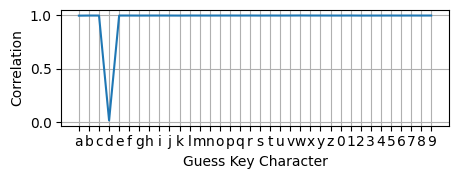

In [2]:
# Select a random trace and compute pearson correlation with all other traces
import random
from scipy.stats import pearsonr

loaded_traces = np.array(loaded_traces)
random_index = random.randint(0, len(loaded_traces) - 1)
random_trace = loaded_traces[random_index]
correlations = [pearsonr(random_trace, trace)[0] for trace in loaded_traces]
plt.figure(figsize=(5, 1.5))
plt.plot(correlations)
# plt.title(f"Pearson Correlation with Random Trace")

# y tickes are the characters
characters = [chr(pt[0]) for pt in loaded_plaintexts]
plt.xticks(ticks=range(len(characters)), labels=characters)
plt.xlabel("Guess Key Character")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()

Average Correlation: 0.9720
Most Divergent Trace Index: 3 with Correlation: 0.0158


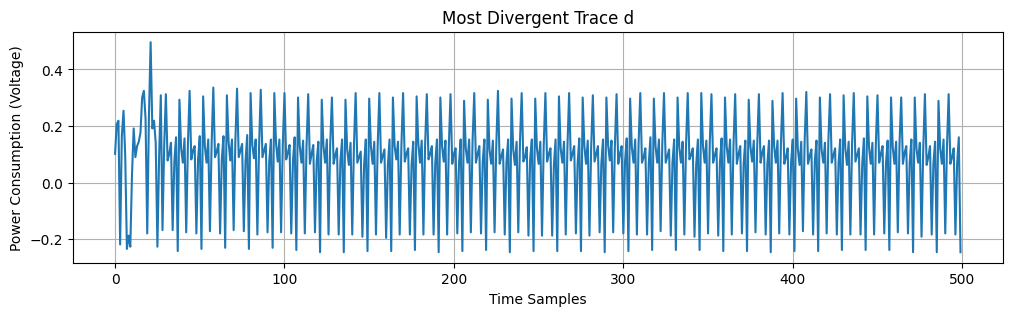

In [3]:
# Find the average correlation and the most divirgent trace and its index
average_correlation = np.mean(correlations)
# This can be lowest correlation as well as highest correlation depending on the random trace
most_divergent_index = np.argmin(correlations) if average_correlation > 0.5 else np.argmax(correlations)
most_divergent_correlation = correlations[most_divergent_index]
print(f"Average Correlation: {average_correlation:.4f}")
print(f"Most Divergent Trace Index: {most_divergent_index} with Correlation: {most_divergent_correlation:.4f}")
# Visualize the most divergent trace
plt.figure(figsize=(12, 3))
plt.plot(loaded_traces[most_divergent_index][:500])
plt.title(f"Most Divergent Trace {chr(loaded_plaintexts[most_divergent_index][0])}")
plt.xlabel("Time Samples")
plt.ylabel("Power Consumption (Voltage)")
plt.grid(True)
plt.show()

# Clustering-based Power Analysis

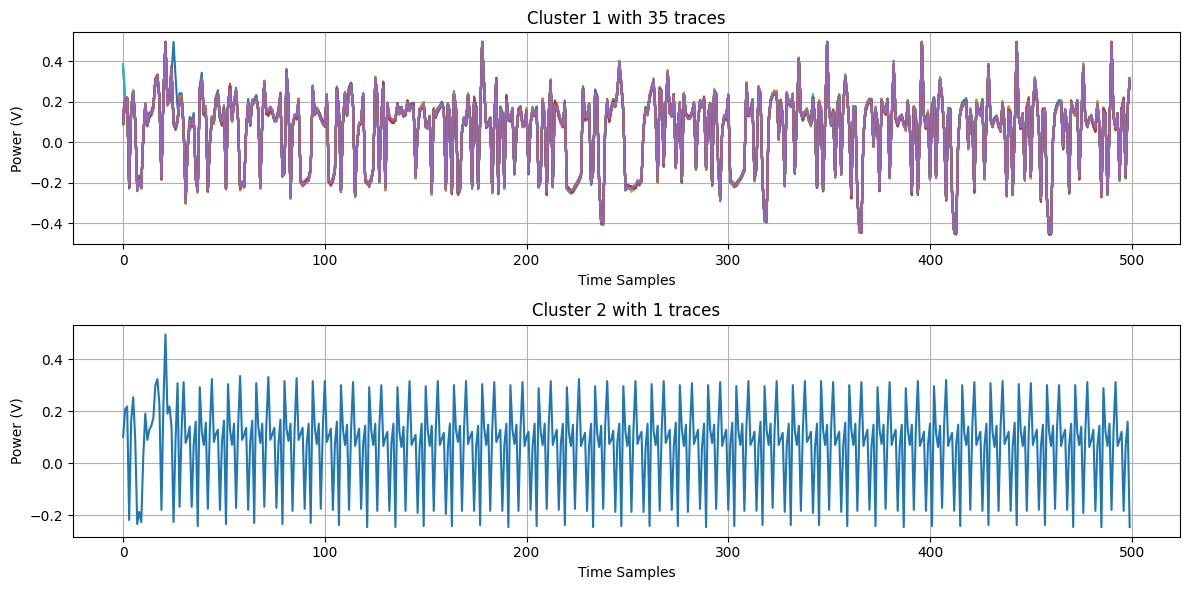

In [ ]:
# Utilize k-means clustering to group similar traces
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(loaded_traces)
labels = kmeans.labels_

# Visualize the clusters need space between subplots
plt.figure(figsize=(12, 6))
for cluster in range(num_clusters):
    plt.subplot(num_clusters, 1, cluster + 1)
    cluster_traces = loaded_traces[labels == cluster]
    for trace in cluster_traces:
        plt.plot(trace[:500])
    plt.title(f"Cluster {cluster + 1} with {len(cluster_traces)} traces")
    plt.xlabel("Time Samples")
    plt.ylabel("Power (V)")
    plt.grid(True)
plt.tight_layout()
plt.show() 

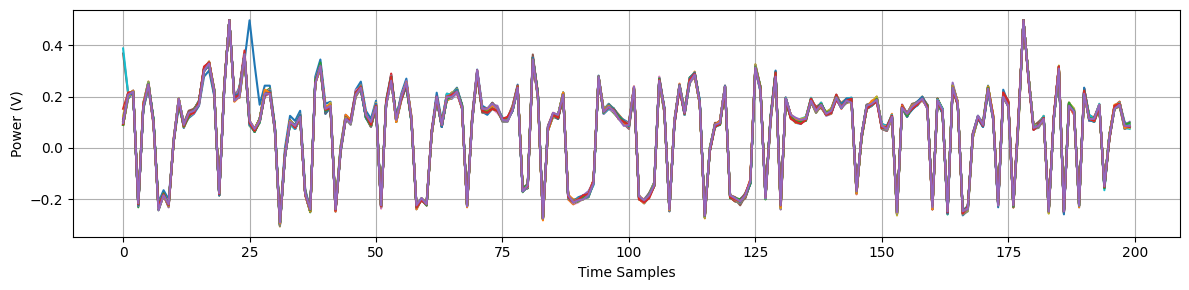

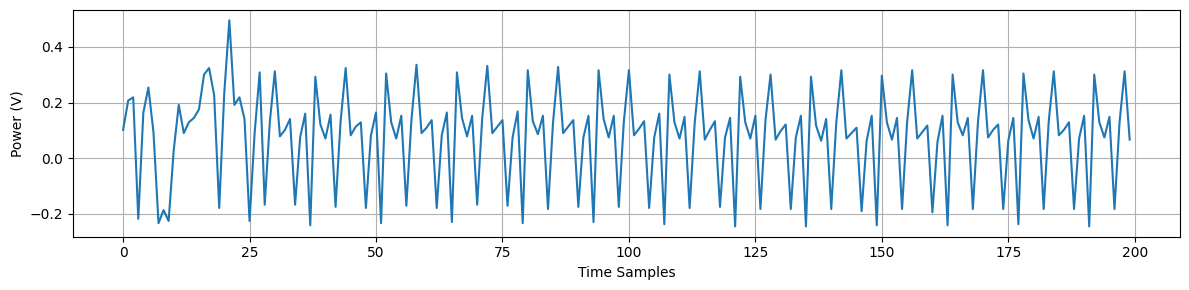

In [5]:
# Visualize the clusters need space between subplots
plt.figure(figsize=(12, 3))
cluster_traces = loaded_traces[labels == 0]
for trace in cluster_traces:
    plt.plot(trace[:200])

# plt.title(f"Cluster {cluster + 1} with {len(cluster_traces)} traces")
plt.xlabel("Time Samples")
plt.ylabel("Power (V)")
plt.grid(True)
plt.tight_layout()
plt.show() 

plt.figure(figsize=(12, 3))
cluster_traces = loaded_traces[labels == 1]
for trace in cluster_traces:
    plt.plot(trace[:200])

# plt.title(f"Cluster {cluster + 1} with {len(cluster_traces)} traces")
plt.xlabel("Time Samples")
plt.ylabel("Power (V)")
plt.grid(True)
plt.tight_layout()
plt.show() 

In [6]:
# Find cluster sizes
cluster_sizes = np.bincount(labels)
for cluster, size in enumerate(cluster_sizes):
    print(f"Cluster {cluster + 1} Size: {size}")

Cluster 1 Size: 35
Cluster 2 Size: 1


Unique Trace Index in Cluster 2: 3


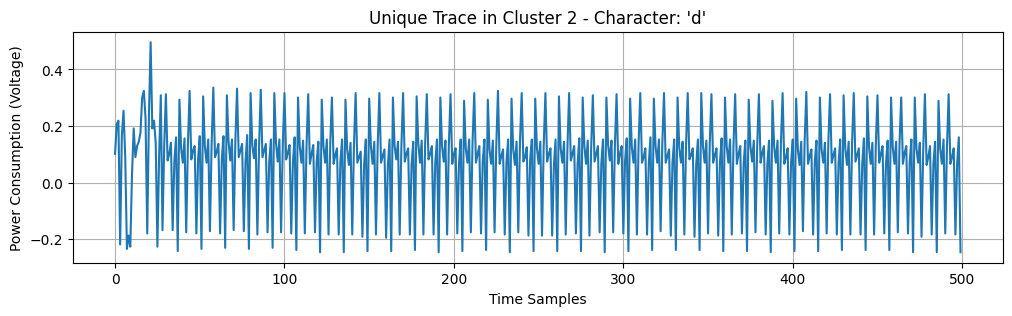

In [7]:
# Find the trace index with cluster size 1
for cluster, size in enumerate(cluster_sizes):
    if size == 1:
        unique_trace_index = np.where(labels == cluster)[0][0]
        print(f"Unique Trace Index in Cluster {cluster + 1}: {unique_trace_index}")
        plt.figure(figsize=(12, 3))
        plt.plot(loaded_traces[unique_trace_index][:500])
        plt.title(f"Unique Trace in Cluster {cluster + 1} - Character: '{chr(loaded_plaintexts[unique_trace_index][0])}'")
        plt.xlabel("Time Samples")
        plt.ylabel("Power Consumption (Voltage)")
        plt.grid(True)
        plt.show()